In [43]:
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline 

from keras.preprocessing.image import load_img
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D,MaxPooling2D
from tensorflow.keras import utils
from keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from PIL import Image 
from sklearn.preprocessing import LabelEncoder


# Creation dataframe données d'entrainement pour l'age et le genre

In [44]:
repertoire_age_list=[]
reference_age_list=[]
face_id_age_list=[]
repertoire_gender_list=[]
reference_gender_list=[]
face_id_gender_list=[]
ages = []
genders=[]


chemin_fichier_age = '/kaggle/input/adience-dataset/train_val_txt_files_per_fold/test_fold_is_3/age_train.txt'
with open(chemin_fichier_age, 'r') as fichier_age:
     for ligne in fichier_age:
# Division de la ligne en référence et âge
           elements = ligne.strip().split()
           if len(elements) == 2:  # il y a deux éléments sur la ligne
                image, age = elements
                repertoire = image.split('/')[0]
                reference=image.split('/')[1]
                face_id = reference.split('.')[1]
                repertoire_age_list.append(repertoire)
                reference_age_list.append(reference)
                face_id_age_list.append(int(face_id))
                ages.append(int(age))  

chemin_fichier_gender ='/kaggle/input/adience-dataset/train_val_txt_files_per_fold/test_fold_is_3/gender_train.txt'
with open(chemin_fichier_gender, 'r') as fichier_gender:
     for ligne in fichier_gender:
# Division de la ligne en référence et âge
           elements = ligne.strip().split()
           if len(elements) == 2:  #il y a deux éléments sur la ligne
                image, gender = elements
                repertoire = image.split('/')[0]
                reference=image.split('/')[1]
                face_id = reference.split('.')[1]
                repertoire_gender_list.append(repertoire)
                reference_gender_list.append(reference)
                face_id_gender_list.append(int(face_id))
                genders.append(int(gender))  

data_age = {'Répertoire': repertoire_age_list, 'Reference_image':reference_age_list,'Face_id':face_id_age_list,'Age': ages}
df_age = pd.DataFrame(data_age)
data_gender = {'Répertoire': repertoire_gender_list, 'Reference_image':reference_gender_list,'Face_id':face_id_gender_list, 'Gender': genders}
df_gender = pd.DataFrame(data_gender)

# Retirer 50% des lignes avec l'âge 4 de manière aléatoire
rows_to_remove = df_age[df_age['Age'] == 4].sample(frac=0.5)  
df_age = df_age.drop(rows_to_remove.index).reset_index(drop=True)
df_age.head(5)



Répertoire                                    Reference_image  Face_id  \
0  114841417@N06  landmark_aligned_face.488.12059875396_f5c3a705...      488   
1   28754132@N06  landmark_aligned_face.612.9367256464_38d751ea5...      612   
2   10792106@N03  landmark_aligned_face.532.11080871614_ee39c8d5...      532   
3   30872264@N00  landmark_aligned_face.603.9206683814_2fe1c35b5...      603   
4   62501130@N02  landmark_aligned_face.97.11305791453_0e7610620...       97   

   Age  
0    3  
1    5  
2    3  
3    5  
4    0

In [45]:
df_gender.shape

(12854, 4)

### equilibre la base pour le genre 

In [46]:
grouped_df = df_gender.groupby('Face_id')
result_df = grouped_df.head(4)
print(result_df)

          Répertoire                                    Reference_image  \
0      114841417@N06  landmark_aligned_face.488.12059875396_f5c3a705...   
1       28754132@N06  landmark_aligned_face.612.9367256464_38d751ea5...   
2       10792106@N03  landmark_aligned_face.532.11080871614_ee39c8d5...   
3       30872264@N00  landmark_aligned_face.603.9206683814_2fe1c35b5...   
4       62501130@N02  landmark_aligned_face.97.11305791453_0e7610620...   
...              ...                                                ...   
12819   10255165@N05  landmark_aligned_face.2034.8321804253_db612b39...   
12839   28468602@N06  landmark_aligned_face.2222.11880076715_f8d00fe...   
12841  113705978@N06  landmark_aligned_face.383.11811853706_9ee8d617...   
12843  115046815@N06  landmark_aligned_face.724.12067854054_500a7148...   
12852    8147776@N04  landmark_aligned_face.2266.9237724854_a38271b1...   

       Face_id  Gender  
0          488       1  
1          612       0  
2          532       1  

In [47]:
df_age.head()

Répertoire                                    Reference_image  Face_id  \
0  114841417@N06  landmark_aligned_face.488.12059875396_f5c3a705...      488   
1   28754132@N06  landmark_aligned_face.612.9367256464_38d751ea5...      612   
2   10792106@N03  landmark_aligned_face.532.11080871614_ee39c8d5...      532   
3   30872264@N00  landmark_aligned_face.603.9206683814_2fe1c35b5...      603   
4   62501130@N02  landmark_aligned_face.97.11305791453_0e7610620...       97   

   Age  
0    3  
1    5  
2    3  
3    5  
4    0

#  Dataframe Global d'entrainement

In [48]:
df_total = pd.merge(df_age, df_gender[['Face_id', 'Gender']], on=['Face_id']).drop_duplicates().sample(frac=1).reset_index(drop=True)

df_total.head()

Répertoire                                    Reference_image  Face_id  \
0   64504106@N06  landmark_aligned_face.911.11849208293_3678bf17...      911   
1   28754132@N06  landmark_aligned_face.610.11546496674_de51a0e1...      610   
2  114841417@N06  landmark_aligned_face.481.12068690463_37335e8d...      481   
3   10241064@N08  landmark_aligned_face.396.8315787822_77c5636c6...      396   
4   34158582@N02  landmark_aligned_face.401.10090156213_ced59dd3...      401   

   Age  Gender  
0    0       0  
1    2       0  
2    7       1  
3    5       0  
4    0       1

# Equilibre de la base de données pour le genre 

In [49]:
resultats_filtrage = df_gender[df_gender['Face_id'] == 261]
print(resultats_filtrage.shape)

(1, 4)


In [50]:
nombre_photos_par_face_id = result_df['Face_id'].value_counts()
face_id_minimum_photos = nombre_photos_par_face_id.idxmin()
print("Nombre de photos par face_id:\n", nombre_photos_par_face_id)
print("\nFace_id avec le minimum de photos:", face_id_minimum_photos)

Nombre de photos par face_id:
 Face_id
488     4
341     4
2119    4
576     4
522     4
       ..
429     1
742     1
278     1
1183    1
2266    1
Name: count, Length: 1729, dtype: int64

Face_id avec le minimum de photos: 572


# Dataframe pour les données de validation 

In [51]:
repertoire_age_list=[]
reference_age_list=[]
face_id_age_list=[]
repertoire_gender_list=[]
reference_gender_list=[]
face_id_gender_list=[]
ages = []
genders=[]


chemin_fichier_age = '/kaggle/input/adience-dataset/train_val_txt_files_per_fold/test_fold_is_3/age_val.txt'
with open(chemin_fichier_age, 'r') as fichier_age:
     for ligne in fichier_age:
# Division de la ligne en référence et âge
           elements = ligne.strip().split()
           if len(elements) == 2:  # il y a deux éléments sur la ligne
                image, age = elements
                repertoire = image.split('/')[0]
                reference=image.split('/')[1]
                face_id = reference.split('.')[1]
                repertoire_age_list.append(repertoire)
                reference_age_list.append(reference)
                face_id_age_list.append(int(face_id))
                ages.append(int(age))  
                
chemin_fichier_gender ='/kaggle/input/adience-dataset/train_val_txt_files_per_fold/test_fold_is_3/gender_val.txt'
with open(chemin_fichier_gender, 'r') as fichier_gender:
     for ligne in fichier_gender:
# Division de la ligne en référence et âge
           elements = ligne.strip().split()
           if len(elements) == 2:  #il y a deux éléments sur la ligne
                image, gender = elements
                repertoire = image.split('/')[0]
                reference=image.split('/')[1]
                face_id = reference.split('.')[1]
                repertoire_gender_list.append(repertoire)
                reference_gender_list.append(reference)
                face_id_gender_list.append(int(face_id))
                genders.append(int(gender))  

data_age_val= {'Répertoire': repertoire_age_list, 'Reference_image':reference_age_list,'Face_id':face_id_age_list,'Age': ages}
df_age_val= pd.DataFrame(data_age_val)
data_gender_val = {'Répertoire': repertoire_gender_list, 'Reference_image':reference_gender_list,'Face_id':face_id_gender_list, 'Gender': genders}
df_gender_val = pd.DataFrame(data_gender_val)

# Retirer 50% des lignes avec l'âge 4 de manière aléatoire
rows_to_remove = df_age_val[df_age_val['Age'] == 4].sample(frac=0.5)  
df_age_val = df_age_val.drop(rows_to_remove.index).reset_index(drop=True)
df_age_val.head()
df_gender_val.head()

Répertoire                                    Reference_image  Face_id  \
0  30872264@N00  landmark_aligned_face.601.9203902773_808c03856...      601   
1  10792106@N03  landmark_aligned_face.542.11040395036_69199ba1...      542   
2  20254529@N04  landmark_aligned_face.18.9404687712_3a2416bb1c...       18   
3  62501130@N02  landmark_aligned_face.97.11298597383_d7bc7bcca...       97   
4  20632896@N03  landmark_aligned_face.572.9827127313_67f83ace3...      572   

   Gender  
0       1  
1       0  
2       0  
3       1  
4       1

In [52]:
df_total_val = pd.merge(df_age_val, df_gender_val[['Face_id', 'Gender']], on=['Face_id']).drop_duplicates().sample(frac=1).reset_index(drop=True)

df_total_val.head()

Répertoire                                    Reference_image  Face_id  \
0  115321157@N03  landmark_aligned_face.1744.12123771626_3852637...     1744   
1   45666944@N00  landmark_aligned_face.408.11842582184_60520540...      408   
2   10792106@N03  landmark_aligned_face.521.11043053933_00680449...      521   
3   37303189@N08  landmark_aligned_face.84.8584898452_c5d3e44353...       84   
4   64504106@N06  landmark_aligned_face.920.11813137435_09deaf0b...      920   

   Age  Gender  
0    1       0  
1    5       0  
2    3       0  
3    0       0  
4    5       0

# Analyse des données

### Distribution de l'âge pour le training

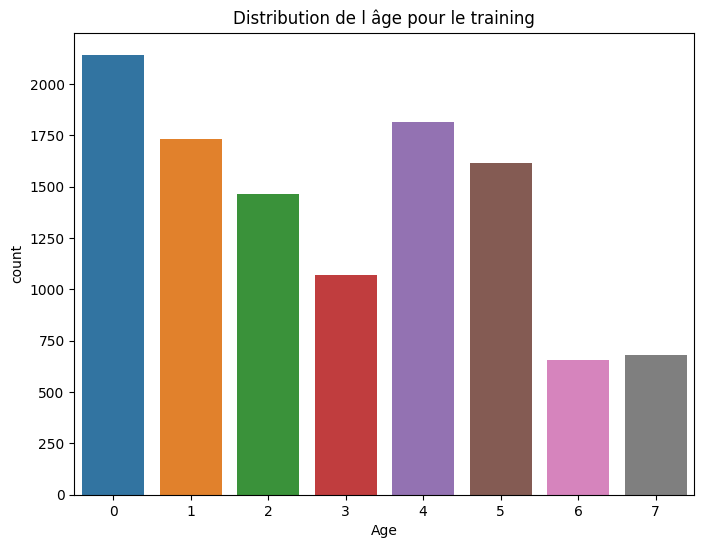

In [53]:

plt.figure(figsize=(8, 6))
sns.countplot(x='Age', data=df_age)
plt.title('Distribution de l âge pour le training')
plt.show()

### Distribution du genre pour le training

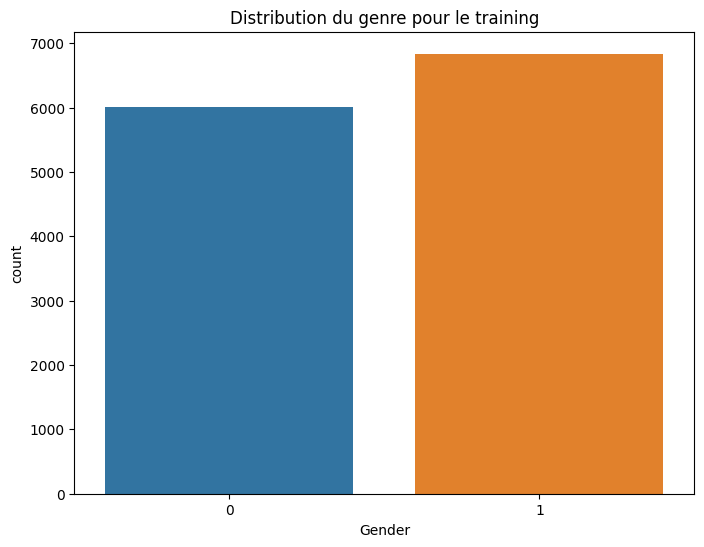

In [54]:

plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=df_gender)
plt.title('Distribution du genre pour le training')
plt.show()

## dimension des images de la base de données

(816, 816)


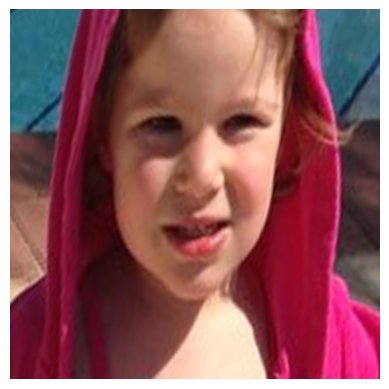

In [55]:
 
from PIL import Image 
img= Image.open('/kaggle/input/images-aligned/aligned/'+df_age['Répertoire'][6]+'/'+df_age['Reference_image'][6])
plt.axis('off')
plt.imshow(img)
shape = img.size
print(shape)


## Analyse Visuelle des données

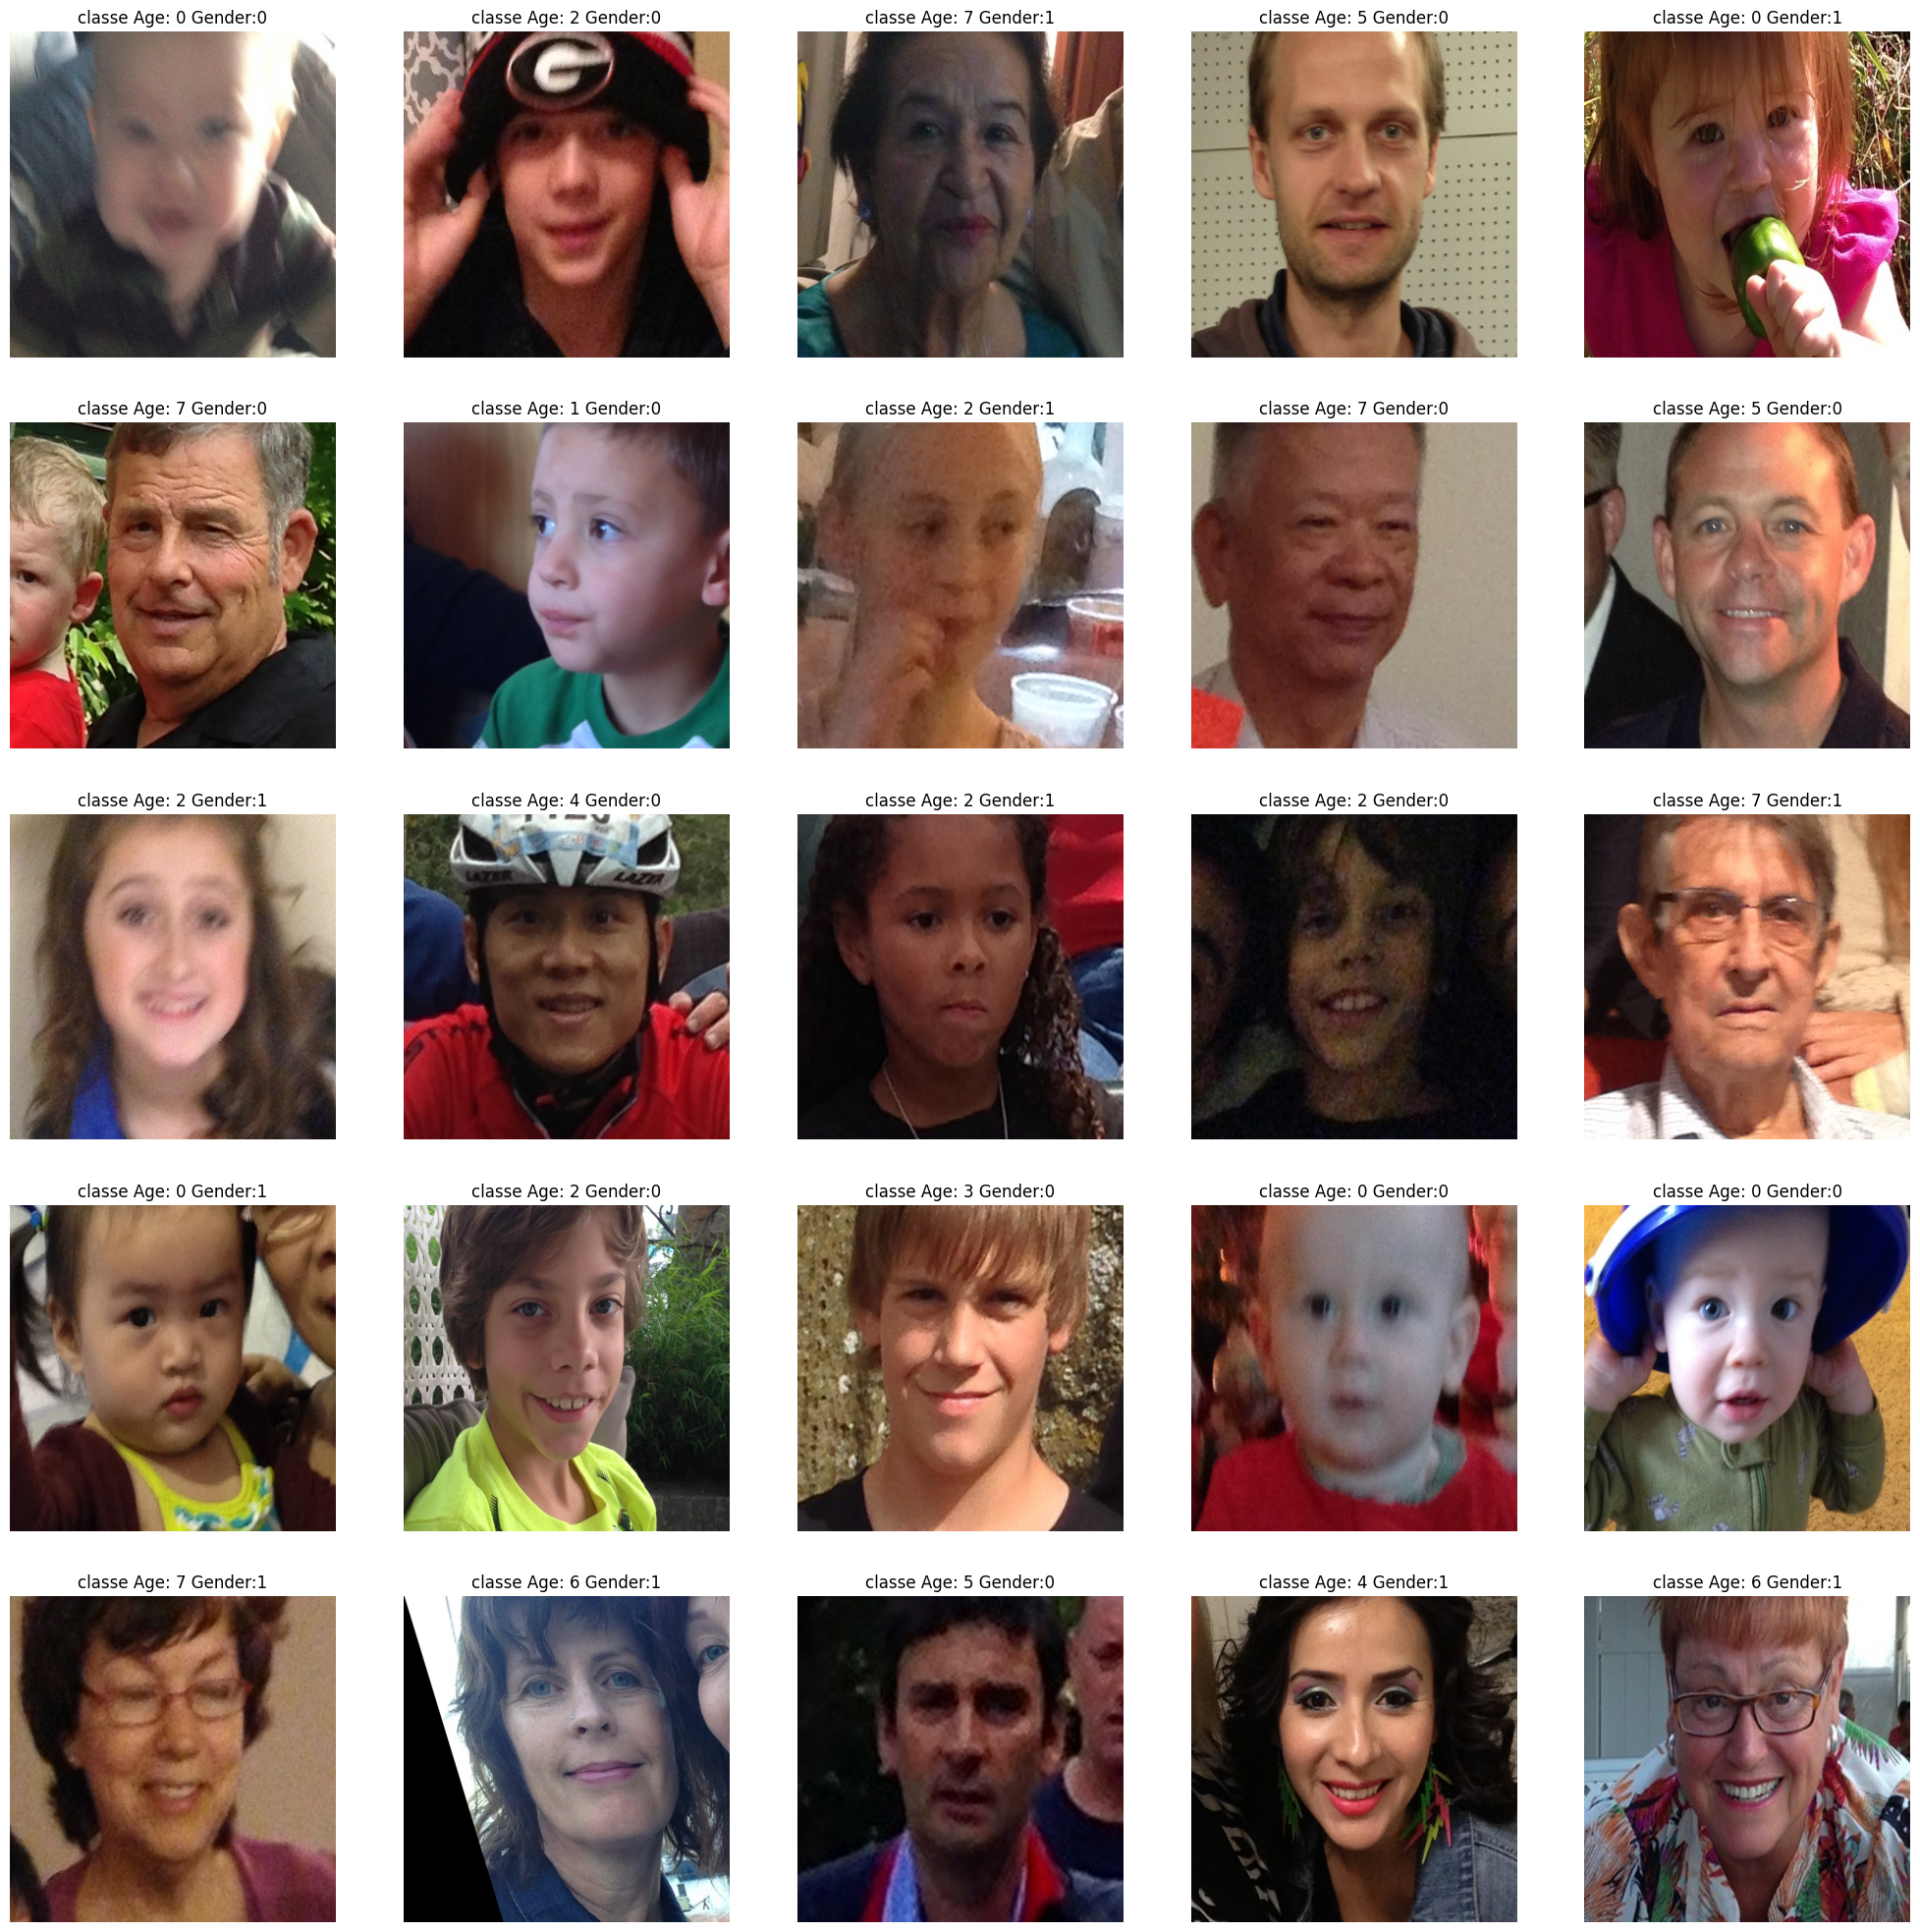

In [56]:

plt.figure(figsize=(25,25))
files =df_total.iloc[0:25]
#map for gender
gender_dict = {0: 'Male', 1 :'Female'}
for index, repertoire, reference,face_id, age , gender in files.itertuples() : 
    plt.subplot(5,5,index+1)
    img = load_img('/kaggle/input/images-aligned/aligned/'+str(repertoire)+'/'+str(reference))
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"classe Age: {age} Gender:{gender}")
    plt.axis('off')
    
    

# Feature Extraction 


In [57]:
def extract_features(images):
    features= []
    for image in tqdm(images): 
        img= load_img('/kaggle/input/images-aligned/aligned/'+image)
        img= img.resize((128,128), Image.ANTIALIAS)
        img=np.array(img)
        features.append(img)
        
    features = np.array(features)
    features=features.reshape(len(features),128,128,3)
    return features

### Extraction des caractéristiques pour données d'entrainement et validation

In [58]:

X_train = extract_features(df_total['Répertoire']+'/'+df_total['Reference_image'])
X_val = extract_features(df_total_val['Répertoire']+'/'+df_total_val['Reference_image'])

y_gender_train= np.array(df_total['Gender'])
y_age_train= np.array(df_total['Age'])
y_gender_val= np.array(df_total_val['Gender'])
y_age_val= np.array(df_total_val['Age'])

  0%|          | 0/10168 [00:00<?, ?it/s]

  0%|          | 0/1138 [00:00<?, ?it/s]

### Normalisation des caractéristiques 

In [59]:
X_train= X_train/255.0
X_val= X_val/255

### Conversion des labes pour l'age

In [60]:
label_encoder = LabelEncoder()
y_train_age_encoded = label_encoder.fit_transform(y_age_train)
y_val_age_encoded = label_encoder.fit_transform(y_age_val)


y_train_age_categorical = to_categorical(y_train_age_encoded, num_classes=8)
y_val_age_categorical = to_categorical(y_val_age_encoded, num_classes=8)


### Configuration de la taille de l'image input

In [61]:
input_shape=(128,128,3)

# Creation Modele pour Age

In [62]:

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))  
model.add(Dense(8, activation='softmax',name='age_out')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

### entrainement de modele 

In [63]:

history_age=model.fit(x=X_train, y=y_train_age_categorical, batch_size=32, epochs=10, validation_data=(X_val,y_val_age_categorical))


Epoch 1/10
318/318 [==============================] - 74s 229ms/step - loss: 1.8180 - accuracy: 0.2792 - val_loss: 1.4995 - val_accuracy: 0.4165
Epoch 2/10
318/318 [==============================] - 68s 215ms/step - loss: 1.3808 - accuracy: 0.4604 - val_loss: 1.2886 - val_accuracy: 0.5255
Epoch 3/10
318/318 [==============================] - 69s 216ms/step - loss: 1.1070 - accuracy: 0.5795 - val_loss: 1.1978 - val_accuracy: 0.5536
Epoch 4/10
318/318 [==============================] - 70s 221ms/step - loss: 0.8679 - accuracy: 0.6754 - val_loss: 1.1290 - val_accuracy: 0.6081
Epoch 5/10
318/318 [==============================] - 71s 222ms/step - loss: 0.6647 - accuracy: 0.7556 - val_loss: 1.1379 - val_accuracy: 0.6028
Epoch 6/10
318/318 [==============================] - 71s 225ms/step - loss: 0.4621 - accuracy: 0.8308 - val_loss: 1.2885 - val_accuracy: 0.6274
Epoch 7/10
318/318 [==============================] - 71s 223ms/step - loss: 0.3470 - accuracy: 0.8762 - val_loss: 1.4089 - val_ac

# Creation Modele pour Genre

In [64]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(16, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(32, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)

#converting 2D array to 1D array
flatten = Flatten() (maxp_3)

# fully connected layers
dense_1 = Dense(75, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)

#sigmoid used for binary classification
output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)

model_gender = Model(inputs=[inputs], outputs=[output_1])
#’adam’ - automatically adjust the learning rate for the model over the no. of epochs
#loss='binary_crossentropy' - loss function for binary outputs (gender)
#mae for the regression classification
#we used accuracy for metrics
#optimizer = Adam(learning_rate=0.0001)
model_gender.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['accuracy'])
model_gender.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496 

### Entrainement de modele

In [ ]:
history_gender=model_gender.fit(x=X_train,y=y_gender_train,batch_size =32, epochs=8, validation_data=(X_val,y_gender_val))

Epoch 1/8
 19/318 [>.............................] - ETA: 1:19 - loss: 0.6923 - accuracy: 0.5247

# Télechargement des modéles entrainés 

In [ ]:
model.save('modele_age.h5')

In [ ]:
model_gender.save('modele_gender.h5')

### Training and validation accuracy for age 

In [ ]:
history = history_age.history
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy for age')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Training and validation Loss for age

In [ ]:
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss for age')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Training and validation accuracy for gender

In [ ]:

history = history_gender.history
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy for gender')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




### Training and validation Loss for gender

In [ ]:
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss for gender')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()